In [1]:
from io import BytesIO

import pandas as pd
import numpy as np
import numpy
import panel as pn
pn.extension('tabulator')
import matplotlib.pyplot as plt
import hvplot.pandas
import matplotlib.gridspec as gridspec
import matplotlib
import holoviews as hv
import param
import scipy
from scipy.signal import find_peaks, peak_prominences

In [2]:
cm = 1/2.54  # centimeters in inches

## Color

In [3]:
from itertools import cycle
main_colours = ['yellow', 'navajowhite', 'orange','orangered','red','darkslateblue','mediumpurple','green','yellowgreen','cyan','lightblue']
l_main_colours = cycle(main_colours)
r_main_colours = cycle(main_colours[::-1])
l_sub_colours = cycle(main_colours)
r_sub_colours = cycle(main_colours[::-1])

In [4]:
def get_number_of_rows(dataframe):
    df = pd.read_csv(dataframe)
    return df.shape[0]

In [5]:
def iqr(array):
    q3, q1 = np.percentile(array,[75,25])
    IQR = q3 - q1
    upper_bound = q3 + 1.5*IQR
    lower_bound = q1 - 1.5*IQR
    return lower_bound, upper_bound

In [6]:
@pn.cache
def fetch_data(dataframe_list):
    size = []
    data_frames = []
    for data in dataframe_list:
        df = pd.read_csv(data)
        df.drop('time', axis = 1, inplace = True)
        df.insert(0,'time',df.index.values)
        df = df.fillna(0)
        size.append(df.shape[0])
        data_frames.append(df)
        minsize = min(size)
    return data_frames, minsize


def cut_data(df, maxsize):
    for column in df.keys():
        upper_bound = maxsize
        df = df[df[column] < upper_bound ]
    return df

## Define widgets

In [7]:
file_input = pn.widgets.FileInput( sizing_mode='stretch_width',
                                  multiple=True)

In [8]:
def show_peaks(limbangle, ERROR = 50):
    limbangle = np.asarray(limbangle)
    peaks, _ = scipy.signal.find_peaks(x = limbangle, height = 0, prominence=(4, None))
    prominences = peak_prominences(limbangle, peaks)[0]
    contour_heights = limbangle[peaks] - prominences

    index = []
    i = 0
    for item in peaks:
        if limbangle[item] < ERROR:
            index.append(i)
        i += 1
    peaks = np.delete(peaks, index)
    contour_heights = np.delete(contour_heights,index)
    return peaks, contour_heights


In [9]:
columns = ['shoulder','elbow','knee','hip']
select_column = pn.widgets.Select(options=columns)
direction = ['l','r']
select_direction =  pn.widgets.Select(options=direction)

In [10]:
def plot(data = None, limb = 'shoulder',direction = 'l', size = (50*cm, 25*cm)):
    fig =  plt.figure(num=1, clear=True, figsize=size)
    spec = fig.add_gridspec(ncols=2, nrows=2)
    ax0 = fig.add_subplot(spec[0, :])
    ax1 = fig.add_subplot(spec[1, 0])
    ax2 = fig.add_subplot(spec[1, 1])
    ymax = 1.0
    if file_input.filename != None:    
        dataframes, min_size = fetch_data(file_input.filename)
        for data in dataframes:
            data = cut_data(data, min_size)
            limbLangle = scipy.signal.savgol_filter(data[limb + "L" + "angle"].to_numpy(),51,3)
            limbRangle = scipy.signal.savgol_filter(data[limb + "R" + "angle"].to_numpy(),51,3)
            ax0.plot(limbLangle,color = next(l_main_colours))
            ax0.plot(limbRangle, color = next(r_main_colours))
            peaks_l, contour_l = show_peaks(limbLangle, 45)
            peaks_r, contour_r = show_peaks(limbRangle, 45)
            ax0.plot(peaks_l, limbLangle[peaks_l], "x")
            ax0.vlines(x=peaks_l, ymin=contour_l, ymax=limbLangle[peaks_l])
            ax0.plot(peaks_r, limbRangle[peaks_r], "x")
            ax0.vlines(x=peaks_r, ymin=contour_r, ymax=limbRangle[peaks_r])
            ax0.set_title(limb + "L" + "angle & "+limb +"R" + "angle")
            if ax0.get_ylim()[1] > ymax:
                ymax = ax0.get_ylim()[1]
            ax1.set_title(limb + "L" + "angle")
            ax1.plot(limbLangle,color = next(l_sub_colours))
            ax2.set_title(limb + "R" + "angle")
            ax2.plot(limbRangle, color = next(r_sub_colours))
            peaks_l, contour_l = show_peaks(limbLangle, 45)
            peaks_r, contour_r = show_peaks(limbRangle, 45)

            ax1.plot(peaks_l, limbLangle[peaks_l], "x")
            ax1.vlines(x=peaks_l, ymin=contour_l, ymax=limbLangle[peaks_l])
            ax2.plot(peaks_r, limbRangle[peaks_r], "x")
            ax2.vlines(x=peaks_r, ymin=contour_r, ymax=limbRangle[peaks_r])
        fig.set_size_inches(size)
        ax0.set_ylim(0,ymax)
        ax1.set_ylim(0,ymax)
        ax2.set_ylim(0,ymax)
        ax0.set(xlabel='frequency (Hz)', ylabel='amplitude (degrees)')
        ax1.set(xlabel='frequency (Hz)', ylabel='amplitude (degrees)')
        ax2.set(xlabel='frequency (Hz)', ylabel='amplitude (degrees)')
    return fig

## Define context binding widgets

In [11]:
def upload_files(files_ = None):
    if file_input.filename != None:
        file_input.save(file_input.filename)

selected = pn.bind(upload_files,file_input, watch = True)


In [12]:
selector = pn.widgets.MultiSelect(name=' ', sizing_mode='stretch_width',
options=['Add your files here'])

def update_selector(selector_widget = None, input = None):
    if file_input.filename != None:
        selector.options = file_input.filename
    else:
        selector.options =['Add your files here']
    return selector
selector_widget = pn.bind(update_selector, selector, file_input, watch = True)



## Debug button

In [13]:
button = pn.widgets.Button(name='Debug', button_type='primary')
text = pn.widgets.TextInput(value='Ready')

def b(event):
    breakpoint()
def debug(event):
    breakpoint()
button.on_click(b)


Watcher(inst=Button(button_type='primary', name='Debug'), cls=<class 'panel.widgets.button.Button'>, fn=<function b at 0x7f92a3fae820>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

## Tab 1 (sidebar & main tab 1)

In [14]:
exercises = ['e-pong','e-Invaders','e-Puzzle','e-Counter']
selected_exercises = pn.widgets.Select(options = exercises)

In [15]:
def iqr(array):
    q3, q1 = np.percentile(array,[75,25])
    IQR = q3 - q1
    upper_bound = q3 + 1.5*IQR
    lower_bound = q1 - 1.5*IQR
    return lower_bound, upper_bound

In [16]:
def boxplot(ywq = None, sdsd = None,direction = 'l'):
    labels = ['left','right']
    fig =  plt.figure(num=1, clear=True, figsize=(15*cm, 8*cm))
    spec = fig.add_gridspec(ncols=2, nrows=2)
    ax0 = fig.add_subplot(spec[0, 0])
    ax1 = fig.add_subplot(spec[0, 1])
    ax2 = fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[1, 1])
    data = selector.value
    limb = ["shoulder","knee","hip","elbow"]
    if not not data: 
        df = fetch_data(data)[0][0]
        ax0.boxplot((df[limb[0] + "L" + "angle"].to_numpy(),df[limb[0] + "R" + "angle"].to_numpy() ), notch=True, vert = True, patch_artist= True, labels=labels)
        ax0.yaxis.grid(True)
        #ax0.set_xlabel('Three separate samples')
        ax0.set_ylabel('Observed values')
        ax0.set_title('Shoulder')

        ax1.boxplot((df[limb[1] + "L" + "angle"].to_numpy(),df[limb[1] + "R" + "angle"].to_numpy() ), notch=True, vert = True, patch_artist= True, labels=labels)
        ax1.yaxis.grid(True)
        #ax1.set_xlabel('Three separate samples')
        ax1.set_ylabel('Observed values')
        ax1.set(xlabel='frequency (Hz)', ylabel='amplitude (degrees)')
        ax1.set_title('Hip')


        ax2.boxplot((df[limb[2] + "L" + "angle"].to_numpy(),df[limb[2] + "R" + "angle"].to_numpy() ), notch=True, vert = True, patch_artist= True, labels=labels)
        ax2.yaxis.grid(True)
        #ax2.set_xlabel('Three separate samples')
        ax2.set_ylabel('Observed values')
        ax2.set_title('Knee')
        ax2.set(xlabel='frequency (Hz)', ylabel='amplitude (degrees)')

        ax3.boxplot((df[limb[3] + "L" + "angle"].to_numpy(),df[limb[3] + "R" + "angle"].to_numpy() ), notch=True, vert = True, patch_artist= True, labels=labels)
        ax3.yaxis.grid(True)
        #ax3.set_xlabel('Three separate samples')
        ax3.set_ylabel('Observed values')
        ax3.set_title('Elbow')
        ax3.set(xlabel='frequency (Hz)', ylabel='amplitude (degrees)')
    return fig

## Tab 2

In [17]:
def plot_details(data = None, limb = 'shoulder', direction = 'l', size = (10, 6)):
    fig =   plt.figure(num=1, clear=True, figsize=size)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0, :])
    if not not selector.value:
        data, min_size = fetch_data(selector.value)
        [data] = data
        limbLangle = scipy.signal.savgol_filter(data[limb + "L" + "angle"].to_numpy(),51,3)
        limbRangle = scipy.signal.savgol_filter(data[limb + "R" + "angle"].to_numpy(),51,3)
        ax.plot(limbLangle,color = next(l_main_colours))
        ax.plot(limbRangle, color = next(r_main_colours))
        peaks_l, contour_l = show_peaks(limbLangle, 45)
        peaks_r, contour_r = show_peaks(limbRangle, 45) 

        ax.plot(peaks_l, limbLangle[peaks_l], "x")
        ax.vlines(x=peaks_l, ymin=contour_l, ymax=limbLangle[peaks_l])
        ax.plot(peaks_r, limbRangle[peaks_r], "x")
        ax.vlines(x=peaks_r, ymin=contour_r, ymax=limbRangle[peaks_r])
        ax.set_title(limb + "L" + "angle & "+limb +"R" + "angle") 
        ax.set(xlabel='frequency (Hz)', ylabel='amplitude (degrees)')
    return fig



In [18]:

details_widget = pn.bind(plot_details,selector, select_column, selector_widget,watch= True)
boxplot_widget = pn.bind(boxplot,selector,selector_widget,watch= True)
main_widget = pn.bind(plot,file_input,select_column,select_direction, watch = True)


## Documentation

In [19]:
doc_markdown = ''' ## Cluster Description **Cluster 3** * **Movement characteristics:** Movement predominantly in the transverse plane, with internal and external rotations of the arm and smooth movement of the elbow.

There is little involvement of other upper joints, with low range of motion. Also note slight movement of the knees.

**Cluster 1** * **Movement characteristics:** Movement with very limited range of motion in all parts of the limbs.

**Cluster 2** * **Movement characteristics:** Broad and comprehensive movement of the arm, exploring several planes of motion. '''

In [20]:
markdown = pn.pane.Markdown(doc_markdown)

## Create the Template

Launching server at http://localhost:44949


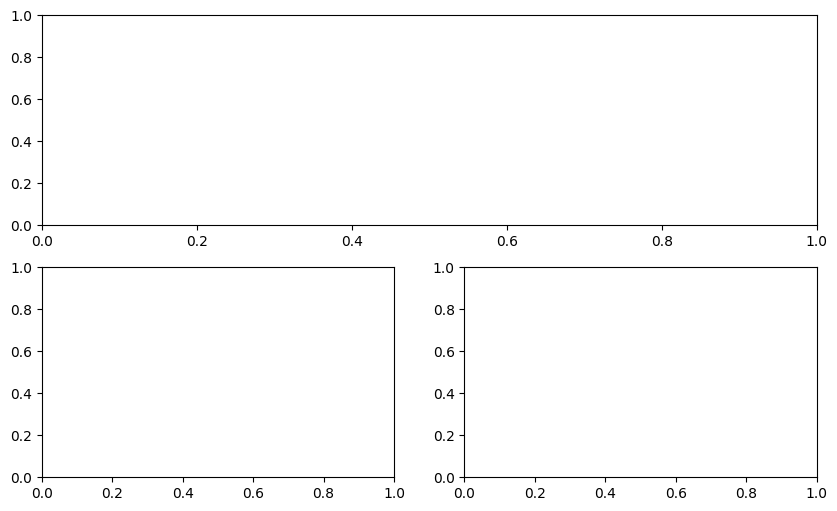

In [21]:
#Layout using Template
template = pn.template.BootstrapTemplate(
    title='Data analysis for motor disabilities rehabilitation of the upper limbs using augmented reality', 
    sidebar=[pn.pane.Markdown(""), 
             file_input,
             button,
             select_column,
             select_direction,
             pn.pane.Markdown("### Selected Files"), 
             selector_widget
            ],
    main=[ pn.Tabs(("Main", main_widget),("Details", pn.Row(details_widget, boxplot_widget)), ("Documentation", markdown))],
    header_background='purple',
)
template.show()
template.servable();